
# Histogram of Oriented Gradients

The Histogram of Oriented Gradient (HOG) feature descriptor is popular
for object detection [1]_.

In the following example, we compute the [HOG descriptor](https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients)_
and display a visualisation.

## Algorithm overview

Compute a Histogram of Oriented Gradients (HOG) by

1. (optional) global image normalisation
2. computing the gradient image in x and y
3. computing gradient histograms
4. normalising across blocks
5. flattening into a feature vector

The first stage applies an optional global image normalisation
equalisation that is designed to reduce the influence of illumination
effects. In practice we use gamma (power law) compression, either
computing the square root or the log of each color channel.
Image texture strength is typically proportional to the local surface
illumination so this compression helps to reduce the effects of local
shadowing and illumination variations.

The second stage computes first order image gradients. These capture
contour, silhouette and some texture information, while providing
further resistance to illumination variations. The locally dominant
color channel is used, which provides color invariance to a large
extent. Variant methods may also include second order image derivatives,
which act as primitive bar detectors - a useful feature for capturing,
e.g. bar like structures in bicycles and limbs in humans.

The third stage aims to produce an encoding that is sensitive to
local image content while remaining resistant to small changes in
pose or appearance. The adopted method pools gradient orientation
information locally in the same way as the SIFT [2]_
feature. The image window is divided into small spatial regions,
called "cells". For each cell we accumulate a local 1-D histogram
of gradient or edge orientations over all the pixels in the
cell. This combined cell-level 1-D histogram forms the basic
"orientation histogram" representation. Each orientation histogram
divides the gradient angle range into a fixed number of
predetermined bins. The gradient magnitudes of the pixels in the
cell are used to vote into the orientation histogram.

The fourth stage computes normalisation, which takes local groups of
cells and contrast normalises their overall responses before passing
to next stage. Normalisation introduces better invariance to illumination,
shadowing, and edge contrast. It is performed by accumulating a measure
of local histogram "energy" over local groups of cells that we call
"blocks". The result is used to normalise each cell in the block.
Typically each individual cell is shared between several blocks, but
its normalisations are block dependent and thus different. The cell
thus appears several times in the final output vector with different
normalisations. This may seem redundant but it improves the performance.
We refer to the normalised block descriptors as Histogram of Oriented
Gradient (HOG) descriptors.

The final step collects the HOG descriptors from all blocks of a dense
overlapping grid of blocks covering the detection window into a combined
feature vector for use in the window classifier.

## References

.. [1] Dalal, N. and Triggs, B., "Histograms of Oriented Gradients for
       Human Detection," IEEE Computer Society Conference on Computer
       Vision and Pattern Recognition, 2005, San Diego, CA, USA.

.. [2] David G. Lowe, "Distinctive image features from scale-invariant
       keypoints," International Journal of Computer Vision, 60, 2 (2004),
       pp. 91-110.


In [ ]:
# def astronaut():
#     """Color image of the astronaut Eileen Collins.

#     Photograph of Eileen Collins, an American astronaut. She was selected
#     as an astronaut in 1992 and first piloted the space shuttle STS-63 in
#     1995. She retired in 2006 after spending a total of 38 days, 8 hours
#     and 10 minutes in outer space.

#     This image was downloaded from the NASA Great Images database
#     <https://flic.kr/p/r9qvLn>`__.

#     No known copyright restrictions, released into the public domain.

#     Returns
#     -------
#     astronaut : (512, 512, 3) uint8 ndarray
#         Astronaut image.
#     """

#     return _load("image2.jpeg")

In [9]:
import numpy as np

from . import _hoghistogram
# from .._shared import utils


def _hog_normalize_block(block, method, eps=1e-5):
    if method == 'L1':
        out = block / (np.sum(np.abs(block)) + eps)
    elif method == 'L1-sqrt':
        out = np.sqrt(block / (np.sum(np.abs(block)) + eps))
    elif method == 'L2':
        out = block / np.sqrt(np.sum(block**2) + eps**2)
    elif method == 'L2-Hys':
        out = block / np.sqrt(np.sum(block**2) + eps**2)
        out = np.minimum(out, 0.2)
        out = out / np.sqrt(np.sum(out**2) + eps**2)
    else:
        raise ValueError('Selected block normalization method is invalid.')

    return out


def _hog_channel_gradient(channel):
    """Compute unnormalized gradient image along `row` and `col` axes.

    Parameters
    ----------
    channel : (M, N) ndarray
        Grayscale image or one of image channel.

    Returns
    -------
    g_row, g_col : channel gradient along `row` and `col` axes correspondingly.
    """
    g_row = np.empty(channel.shape, dtype=channel.dtype)
    g_row[0, :] = 0
    g_row[-1, :] = 0
    g_row[1:-1, :] = channel[2:, :] - channel[:-2, :]
    g_col = np.empty(channel.shape, dtype=channel.dtype)
    g_col[:, 0] = 0
    g_col[:, -1] = 0
    g_col[:, 1:-1] = channel[:, 2:] - channel[:, :-2]

    return g_row, g_col


@utils.channel_as_last_axis(multichannel_output=False)
def hog(
    image,
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(3, 3),
    block_norm='L2-Hys',
    visualize=False,
    transform_sqrt=False,
    feature_vector=True,
    *,
    channel_axis=None,
):
    """Extract Histogram of Oriented Gradients (HOG) for a given image.

    Compute a Histogram of Oriented Gradients (HOG) by

        1. (optional) global image normalization
        2. computing the gradient image in `row` and `col`
        3. computing gradient histograms
        4. normalizing across blocks
        5. flattening into a feature vector

    Parameters
    ----------
    image : (M, N[, C]) ndarray
        Input image.
    orientations : int, optional
        Number of orientation bins.
    pixels_per_cell : 2-tuple (int, int), optional
        Size (in pixels) of a cell.
    cells_per_block : 2-tuple (int, int), optional
        Number of cells in each block.
    block_norm : str {'L1', 'L1-sqrt', 'L2', 'L2-Hys'}, optional
        Block normalization method:

        ``L1``
           Normalization using L1-norm.
        ``L1-sqrt``
           Normalization using L1-norm, followed by square root.
        ``L2``
           Normalization using L2-norm.
        ``L2-Hys``
           Normalization using L2-norm, followed by limiting the
           maximum values to 0.2 (`Hys` stands for `hysteresis`) and
           renormalization using L2-norm. (default)
           For details, see [3]_, [4]_.

    visualize : bool, optional
        Also return an image of the HOG.  For each cell and orientation bin,
        the image contains a line segment that is centered at the cell center,
        is perpendicular to the midpoint of the range of angles spanned by the
        orientation bin, and has intensity proportional to the corresponding
        histogram value.
    transform_sqrt : bool, optional
        Apply power law compression to normalize the image before
        processing. DO NOT use this if the image contains negative
        values. Also see `notes` section below.
    feature_vector : bool, optional
        Return the data as a feature vector by calling .ravel() on the result
        just before returning.
    channel_axis : int or None, optional
        If None, the image is assumed to be a grayscale (single channel) image.
        Otherwise, this parameter indicates which axis of the array corresponds
        to channels.

        .. versionadded:: 0.19
           `channel_axis` was added in 0.19.

    Returns
    -------
    out : (n_blocks_row, n_blocks_col, n_cells_row, n_cells_col, n_orient) ndarray
        HOG descriptor for the image. If `feature_vector` is True, a 1D
        (flattened) array is returned.
    hog_image : (M, N) ndarray, optional
        A visualisation of the HOG image. Only provided if `visualize` is True.

    Raises
    ------
    ValueError
        If the image is too small given the values of pixels_per_cell and
        cells_per_block.

    References
    ----------
    .. [1] https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients

    .. [2] Dalal, N and Triggs, B, Histograms of Oriented Gradients for
           Human Detection, IEEE Computer Society Conference on Computer
           Vision and Pattern Recognition 2005 San Diego, CA, USA,
           https://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf,
           :DOI:`10.1109/CVPR.2005.177`

    .. [3] Lowe, D.G., Distinctive image features from scale-invatiant
           keypoints, International Journal of Computer Vision (2004) 60: 91,
           http://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf,
           :DOI:`10.1023/B:VISI.0000029664.99615.94`

    .. [4] Dalal, N, Finding People in Images and Videos,
           Human-Computer Interaction [cs.HC], Institut National Polytechnique
           de Grenoble - INPG, 2006,
           https://tel.archives-ouvertes.fr/tel-00390303/file/NavneetDalalThesis.pdf

    Notes
    -----
    The presented code implements the HOG extraction method from [2]_ with
    the following changes: (I) blocks of (3, 3) cells are used ((2, 2) in the
    paper); (II) no smoothing within cells (Gaussian spatial window with sigma=8pix
    in the paper); (III) L1 block normalization is used (L2-Hys in the paper).

    Power law compression, also known as Gamma correction, is used to reduce
    the effects of shadowing and illumination variations. The compression makes
    the dark regions lighter. When the kwarg `transform_sqrt` is set to
    ``True``, the function computes the square root of each color channel
    and then applies the hog algorithm to the image.
    """
    image = np.atleast_2d(image)
    float_dtype = utils._supported_float_type(image.dtype)
    image = image.astype(float_dtype, copy=False)

    multichannel = channel_axis is not None
    ndim_spatial = image.ndim - 1 if multichannel else image.ndim
    if ndim_spatial != 2:
        raise ValueError(
            'Only images with two spatial dimensions are '
            'supported. If using with color/multichannel '
            'images, specify `channel_axis`.'
        )

    """
    The first stage applies an optional global image normalization
    equalisation that is designed to reduce the influence of illumination
    effects. In practice we use gamma (power law) compression, either
    computing the square root or the log of each color channel.
    Image texture strength is typically proportional to the local surface
    illumination so this compression helps to reduce the effects of local
    shadowing and illumination variations.
    """

    if transform_sqrt:
        image = np.sqrt(image)

    """
    The second stage computes first order image gradients. These capture
    contour, silhouette and some texture information, while providing
    further resistance to illumination variations. The locally dominant
    color channel is used, which provides color invariance to a large
    extent. Variant methods may also include second order image derivatives,
    which act as primitive bar detectors - a useful feature for capturing,
    e.g. bar like structures in bicycles and limbs in humans.
    """

    if multichannel:
        g_row_by_ch = np.empty_like(image, dtype=float_dtype)
        g_col_by_ch = np.empty_like(image, dtype=float_dtype)
        g_magn = np.empty_like(image, dtype=float_dtype)

        for idx_ch in range(image.shape[2]):
            (
                g_row_by_ch[:, :, idx_ch],
                g_col_by_ch[:, :, idx_ch],
            ) = _hog_channel_gradient(image[:, :, idx_ch])
            g_magn[:, :, idx_ch] = np.hypot(
                g_row_by_ch[:, :, idx_ch], g_col_by_ch[:, :, idx_ch]
            )

        # For each pixel select the channel with the highest gradient magnitude
        idcs_max = g_magn.argmax(axis=2)
        rr, cc = np.meshgrid(
            np.arange(image.shape[0]),
            np.arange(image.shape[1]),
            indexing='ij',
            sparse=True,
        )
        g_row = g_row_by_ch[rr, cc, idcs_max]
        g_col = g_col_by_ch[rr, cc, idcs_max]
    else:
        g_row, g_col = _hog_channel_gradient(image)

    """
    The third stage aims to produce an encoding that is sensitive to
    local image content while remaining resistant to small changes in
    pose or appearance. The adopted method pools gradient orientation
    information locally in the same way as the SIFT [Lowe 2004]
    feature. The image window is divided into small spatial regions,
    called "cells". For each cell we accumulate a local 1-D histogram
    of gradient or edge orientations over all the pixels in the
    cell. This combined cell-level 1-D histogram forms the basic
    "orientation histogram" representation. Each orientation histogram
    divides the gradient angle range into a fixed number of
    predetermined bins. The gradient magnitudes of the pixels in the
    cell are used to vote into the orientation histogram.
    """

    s_row, s_col = image.shape[:2]
    c_row, c_col = pixels_per_cell
    b_row, b_col = cells_per_block

    n_cells_row = int(s_row // c_row)  # number of cells along row-axis
    n_cells_col = int(s_col // c_col)  # number of cells along col-axis

    # compute orientations integral images
    orientation_histogram = np.zeros(
        (n_cells_row, n_cells_col, orientations), dtype=float
    )
    g_row = g_row.astype(float, copy=False)
    g_col = g_col.astype(float, copy=False)

    _hoghistogram.hog_histograms(
        g_col,
        g_row,
        c_col,
        c_row,
        s_col,
        s_row,
        n_cells_col,
        n_cells_row,
        orientations,
        orientation_histogram,
    )

    # now compute the histogram for each cell
    hog_image = None

    if visualize:
        from .. import draw

        radius = min(c_row, c_col) // 2 - 1
        orientations_arr = np.arange(orientations)
        # set dr_arr, dc_arr to correspond to midpoints of orientation bins
        orientation_bin_midpoints = np.pi * (orientations_arr + 0.5) / orientations
        dr_arr = radius * np.sin(orientation_bin_midpoints)
        dc_arr = radius * np.cos(orientation_bin_midpoints)
        hog_image = np.zeros((s_row, s_col), dtype=float_dtype)
        for r in range(n_cells_row):
            for c in range(n_cells_col):
                for o, dr, dc in zip(orientations_arr, dr_arr, dc_arr):
                    centre = tuple([r * c_row + c_row // 2, c * c_col + c_col // 2])
                    rr, cc = draw.line(
                        int(centre[0] - dc),
                        int(centre[1] + dr),
                        int(centre[0] + dc),
                        int(centre[1] - dr),
                    )
                    hog_image[rr, cc] += orientation_histogram[r, c, o]

    """
    The fourth stage computes normalization, which takes local groups of
    cells and contrast normalizes their overall responses before passing
    to next stage. Normalization introduces better invariance to illumination,
    shadowing, and edge contrast. It is performed by accumulating a measure
    of local histogram "energy" over local groups of cells that we call
    "blocks". The result is used to normalize each cell in the block.
    Typically each individual cell is shared between several blocks, but
    its normalizations are block dependent and thus different. The cell
    thus appears several times in the final output vector with different
    normalizations. This may seem redundant but it improves the performance.
    We refer to the normalized block descriptors as Histogram of Oriented
    Gradient (HOG) descriptors.
    """

    n_blocks_row = (n_cells_row - b_row) + 1
    n_blocks_col = (n_cells_col - b_col) + 1
    if n_blocks_col <= 0 or n_blocks_row <= 0:
        min_row = b_row * c_row
        min_col = b_col * c_col
        raise ValueError(
            'The input image is too small given the values of '
            'pixels_per_cell and cells_per_block. '
            'It should have at least: '
            f'{min_row} rows and {min_col} cols.'
        )
    normalized_blocks = np.zeros(
        (n_blocks_row, n_blocks_col, b_row, b_col, orientations), dtype=float_dtype
    )

    for r in range(n_blocks_row):
        for c in range(n_blocks_col):
            block = orientation_histogram[r : r + b_row, c : c + b_col, :]
            normalized_blocks[r, c, :] = _hog_normalize_block(block, method=block_norm)

    """
    The final step collects the HOG descriptors from all blocks of a dense
    overlapping grid of blocks covering the detection window into a combined
    feature vector for use in the window classifier.
    """

    if feature_vector:
        normalized_blocks = normalized_blocks.ravel()

    if visualize:
        return normalized_blocks, hog_image
    else:
        return normalized_blocks

ImportError: attempted relative import with no known parent package

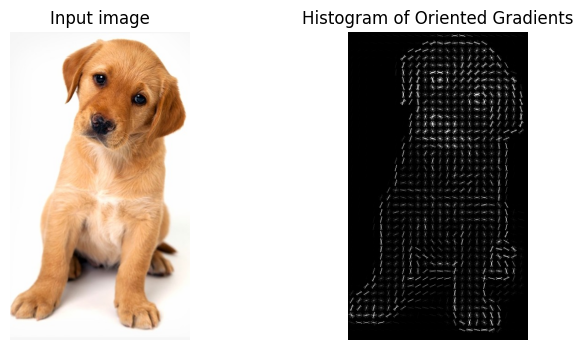

In [5]:
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage.io import imread
from skimage import data, exposure


image = imread('image2.jpeg')

fd, hog_image = hog(
    image,
    orientations=8,
    pixels_per_cell=(16, 16),
    cells_per_block=(1, 1),
    visualize=True,
    channel_axis=-1,
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


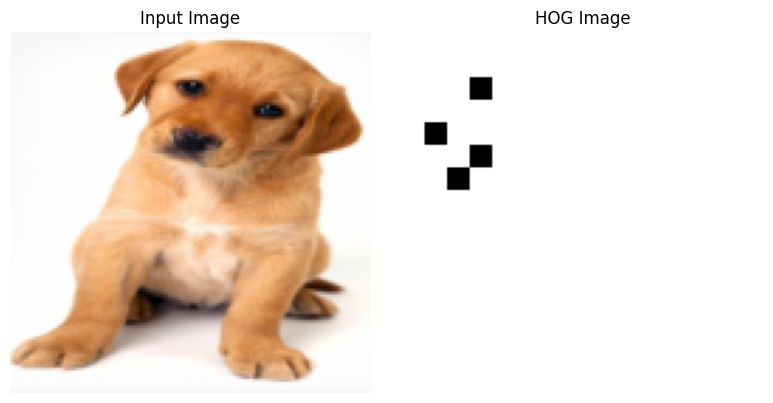

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize
from scipy.signal import convolve2d


def convolve(image, kernel):
    return convolve2d(image, kernel, mode='same', boundary='symm')


def compute_gradients(image):
    # Sobel filter kernels for horizontal and vertical gradients
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]])

    sobel_y = np.array([[-1, -2, -1],
                        [0, 0, 0],
                        [1, 2, 1]])

    # Compute horizontal and vertical gradients using Sobel filters
    gradient_x = convolve(image, sobel_x)
    gradient_y = convolve(image, sobel_y)

    return gradient_x, gradient_y


def compute_magnitude_and_angle(gradient_x, gradient_y):
    # Compute gradient magnitude and angle
    magnitude = np.sqrt(gradient_x ** 2 + gradient_y ** 2)
    angle = np.arctan2(gradient_y, gradient_x) * (180 / np.pi) % 180  # Convert to degrees [0, 180]

    return magnitude, angle


def compute_histogram_cell(magnitude, angle, cell_size, num_bins):
    cell_histogram = np.zeros(num_bins)

    cell_width, cell_height = cell_size
    num_cells_x = magnitude.shape[1] // cell_width
    num_cells_y = magnitude.shape[0] // cell_height

    for i in range(num_cells_y):
        for j in range(num_cells_x):
            start_x = j * cell_width
            start_y = i * cell_height
            end_x = start_x + cell_width
            end_y = start_y + cell_height

            cell_magnitude = magnitude[start_y:end_y, start_x:end_x]
            cell_angle = angle[start_y:end_y, start_x:end_x]

            cell_histogram += compute_cell_histogram(cell_magnitude, cell_angle, num_bins)

    return cell_histogram


def compute_cell_histogram(cell_magnitude, cell_angle, num_bins):
    cell_histogram = np.zeros(num_bins)

    angle_unit = 180 / num_bins

    for i in range(cell_magnitude.shape[0]):
        for j in range(cell_magnitude.shape[1]):
            # Calculate the bin indices
            bin_idx = int(cell_angle[i, j] / angle_unit)

            # Weighted voting
            vote = cell_magnitude[i, j]
            cell_histogram[(bin_idx % num_bins)] += vote * (1 - (abs((cell_angle[i, j] - (bin_idx * angle_unit)) / angle_unit)))

    return cell_histogram


def normalize_blocks(histograms, block_size, num_bins, epsilon=1e-5):
    block_height, block_width = block_size
    num_blocks_x = histograms.shape[1] - block_width + 1
    num_blocks_y = histograms.shape[0] - block_height + 1

    normalized_blocks = np.zeros((num_blocks_y, num_blocks_x, block_height * block_width * num_bins))

    for i in range(num_blocks_y):
        for j in range(num_blocks_x):
            block = histograms[i:i + block_height, j:j + block_width, :].flatten()

            # L2 normalization
            block /= np.sqrt(np.sum(block ** 2) + epsilon ** 2)

            normalized_blocks[i, j, :] = block

    return normalized_blocks


def hog_descriptor(image, cell_size=(8, 8), block_size=(2, 2), num_bins=9):
    gray_image = rgb2gray(image)

    gradient_x, gradient_y = compute_gradients(gray_image)
    magnitude, angle = compute_magnitude_and_angle(gradient_x, gradient_y)

    cell_histograms = np.zeros((magnitude.shape[0] // cell_size[0], magnitude.shape[1] // cell_size[1], num_bins))

    for i in range(cell_histograms.shape[0]):
        for j in range(cell_histograms.shape[1]):
            start_x = j * cell_size[1]
            start_y = i * cell_size[0]
            end_x = start_x + cell_size[1]
            end_y = start_y + cell_size[0]

            cell_histograms[i, j, :] = compute_cell_histogram(
                magnitude[start_y:end_y, start_x:end_x],
                angle[start_y:end_y, start_x:end_x],
                num_bins
            )

    normalized_blocks = normalize_blocks(cell_histograms, block_size, num_bins)

    return normalized_blocks.flatten(), magnitude, angle


def visualize_hog(image, magnitude, angle, cell_size=(8, 8)):
    hog_image = np.zeros_like(image, dtype=float)

    cell_width, cell_height = cell_size
    num_cells_x = magnitude.shape[1] // cell_width
    num_cells_y = magnitude.shape[0] // cell_height

    for i in range(num_cells_y):
        for j in range(num_cells_x):
            start_x = j * cell_width
            start_y = i * cell_height
            end_x = start_x + cell_width
            end_y = start_y + cell_height

            cell_magnitude = magnitude[start_y:end_y, start_x:end_x]
            cell_angle = angle[start_y:end_y, start_x:end_x]

            cell_hog_value = np.max(cell_magnitude) * 0.5

            bin_idx = np.argmax(cell_magnitude)
            bin_angle = cell_angle.ravel()[bin_idx]
            hog_image[start_y:end_y, start_x:end_x] = bin_angle

    return hog_image


# Load the image
image = imread('image2.jpeg')

# Resize image to a fixed size (optional but recommended)
image = resize(image, (128, 128))

# Compute HOG descriptor and visualize HOG image
hog_features, magnitude, angle = hog_descriptor(image)
hog_image = visualize_hog(image, magnitude, angle)

# Visualize the HOG image
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Input Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(hog_image, cmap='jet')
plt.title('HOG Image')
plt.axis('off')

plt.tight_layout()
plt.show()
